# Window Function effect on P(k)

Import some required modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nbodykit.lab as nb
import nbodykit
import fitsio as ft
from time import time
from   glob import glob
import mcfit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
plt.rc('font', size=20)

## Define Functions

* Define a function to facilitate reading Florian's W(k)s            
* Define a Class to read Florian's W^{0}_{ell}, and transform it to real space

Note that we multiply the windows by an exponential function for k>0.02

In [3]:
def read_florian():          
    """ Read Florian's code output """
    
    lbls = 'W^0_0(k) W^0_1(k) W^0_2(k) W^0_3(k) W^0_4(k) W^1_0(k)'\
        +' W^1_1(k) W^1_2(k) W^1_3(k) W^1_4(k) W^2_0(k) W^2_1(k)'\
        +' W^2_2(k) W^2_3(k) W^2_4(k) Nmodes'
    tlb = lbls.split(' ')    
    d = np.loadtxt('/home/mehdi/data/eboss/v6/'\
                   +'win_eBOSS_DR16_QSO_v6_NGC_TSC_600_600_600_10000_merged.dat', 
                   skiprows=30)
    w_dicts = {}
    for i, j in enumerate(range(2, 17)):
        k = d[:, 0]
        w = d[:, j]
        w_dicts[tlb[i]] = w
    return k, w_dicts  


class WINDOWf(object):
    """ Read Florian's output given ell, and transform it real space W(r) """
    def __init__(self):
        k, w_dicts = read_florian()
        self.k     = k
        self.wdict = w_dicts
        
    def __call__(self, ell, fix):
        self.ell = ell
        self.wk  = self.wdict['W^0_%d(k)'%ell].copy()  ## without correction
        self._fixWk(fix) # fix Wk
        #
        
    def _fixWk(self, fix):
        if fix:
            mask      = self.k > 0.02            
            wk_last   = self.wk[~mask][-1]
            k_last    = self.k[~mask][-1]
            
            ## Approach 1: linear damping
            ##funct     = lambda x:np.power(x, -3.8)
            ##self.wk[mask] = self.wk[mask]*funct(self.k[mask])/funct(k_last)*wk_last
            
            ## Approach 2: exponential
            self.wk[mask] = self.wk[mask]*np.exp(-1000*(self.k[mask]-k_last)**2)
                             
    def Wk2Wr(self, kmin=None, kmax=None):
        if kmin is None:
            kmin = self.k.min()
        if kmax is None:
            kmax = self.k.max()
            
        klog = np.logspace(np.log10(kmin), np.log10(kmax), 
                           num=self.k.size, endpoint=True)

        w_interpolated = IUS(self.k, self.wk, ext=1)
        wk_int     = w_interpolated(klog)        
        r,wr       = mcfit.P2xi(klog, l=self.ell)(wk_int)           
        self.r     = r
        self.wr    = wr                
        self.kint  = klog
        self.wkint = wk_int

Let's look at the windows for with and without exponential damping on large-k. The damped version is shown with the black solid line.

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/mcfit/mcfit.py:125: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/mcfit/mcfit.py:219: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


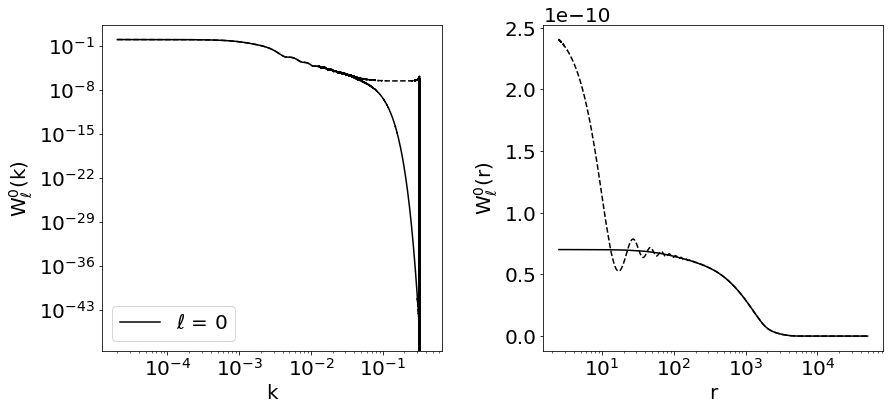

In [4]:
fourier   = WINDOWf()  # initiate the class


color = ['k', 'b', 'purple']
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)
for j,ell in enumerate([0]):
    
    ## with the exponential damping
    fourier(ell, fix=True)
    fourier.Wk2Wr()
    ax[1].plot(fourier.r, fourier.wr, ls='-', color=color[j])
    ax[0].plot(fourier.k, fourier.wk, ls='-', label=r'$\ell$ = %d'%ell, color=color[j])
    
    ## without the damping
    fourier(ell, fix=False)
    fourier.Wk2Wr()
    ax[1].plot(fourier.r, fourier.wr, ls='--', color=color[j])
    ax[0].plot(fourier.k, fourier.wk, ls='--', color=color[j])
    
ax[1].set_xlabel('r')
ax[1].set_ylabel('W$^{0}_{\ell}$(r)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('W$^{0}_{\ell}$(k)')
ax[0].legend(loc=3)
for axi in ax:axi.set_xscale('log')
ax[0].set_yscale('log')

It seems smoothing out the window function after K > 0.02 [h/Mpc], improves the transformation. Let's look at the other multipoles as well

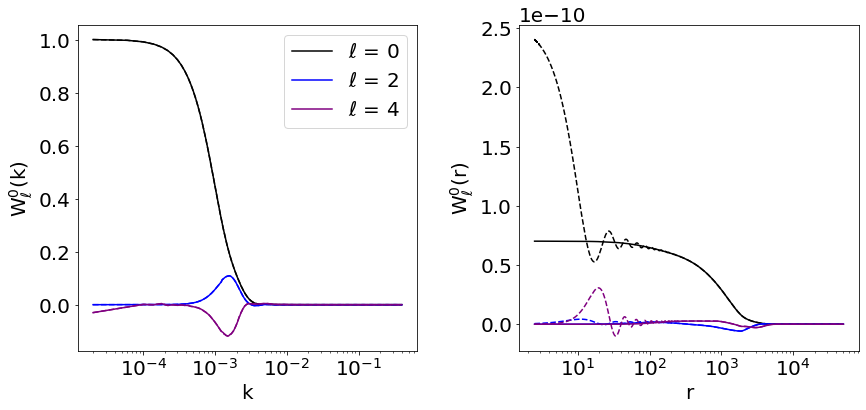

In [5]:
fourier   = WINDOWf()  # initiate the class

color = ['k', 'b', 'purple']
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)

for j,ell in enumerate([0, 2, 4]):
    
    ## with the exponential damping
    fourier(ell, fix=True)
    fourier.Wk2Wr()
    ax[1].plot(fourier.r, fourier.wr, ls='-', color=color[j])
    ax[0].plot(fourier.k, fourier.wk, ls='-', label=r'$\ell$ = %d'%ell, color=color[j])
    
    ## without the damping
    fourier(ell, fix=False)
    fourier.Wk2Wr()
    ax[1].plot(fourier.r, fourier.wr, ls='--', color=color[j])
    ax[0].plot(fourier.k, fourier.wk, ls='--', color=color[j])
    
ax[1].set_xlabel('r')
ax[1].set_ylabel('W$^{0}_{\ell}$(r)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('W$^{0}_{\ell}$(k)')
ax[0].legend(loc=1)
for axi in ax:axi.set_xscale('log')
#ax[0].set_yscale('log')

Save the mutiples 

In [6]:
fourier   = WINDOWf()
R  = []
WR = []
for ell in [0, 2, 4]:
    fourier(ell, fix=True)
    fourier.Wk2Wr()
    R.append(fourier.r)
    WR.append(fourier.wr)
np.savetxt('./Wr_ell.txt', np.column_stack([R[0], WR[0], WR[1], WR[2]]), header=' r W0 W2 w4')    